In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../Dataset/PS_20174392719_1491204439457_log.csv')

<h1><b>1. Data Overview </h1>

<h3>Datasets structure</h3>

In [4]:
df.shape

(6362620, 11)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

Key Insights:
- In the dataset, there are 5 types or transatctions spanning 743 hourly intervals. 
- The nameOrig column has 6353307 unique value out of 6362620 total rows, meaning 9313 people have conducted multiple transactions.

<h3> Summary statistics of numerical features

In [33]:
df.select_dtypes(include=['int64', 'float64']).describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Key Insights:
- <i>step</i> ranges from 1 to 743, where each step represents 1 hour. This suggests the dataset covers approximately 31 days of transaction records (743 ÷ 24 ≈ 31)
- <i>isFraud</i> is highly imbalanced, with a mean of 0.00129, indicating a fraud rate of just 0.129% 

<h1><b>2. Data Cleaning</h1>

<h3>Identifying missing values</h3>

In [8]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

<h3> Checking for duplicate values </h3>

In [9]:
df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


<h3>Detecting outliers</h3>

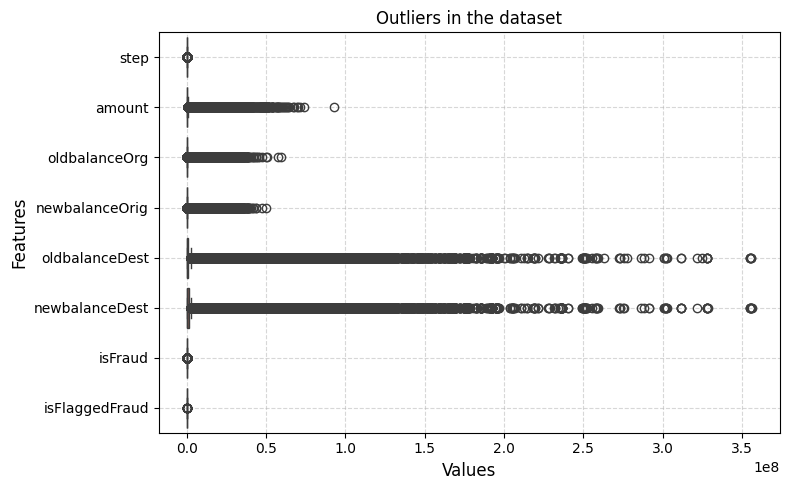

In [34]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, orient='h')
plt.title('Outliers in the dataset')

# Customize the visualization
plt.xlabel('Values', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

This transaction dataset that may came from a bank and the outliers observed here may not necessarily be linked to fraudulent behavior. Features such as old balance origin, new balance origin, old balance destination and new balance destination are all insufficient to directly suggest fraud. These anomalous transactions can be quite common and may not be indicative of fraud. Therefore, it is not justifiable to remove these outliers and they should remain part of the dataset.

<h1><b>3. Explanatory Data Analysis</h1>

<h3>Analysis on the 'Type' field</h3>

In [11]:
type_percentages = round(df['type'].value_counts(normalize=True) * 100, 2)
print(type_percentages)

type
CASH_OUT    35.17
PAYMENT     33.81
CASH_IN     21.99
TRANSFER     8.38
DEBIT        0.65
Name: proportion, dtype: float64


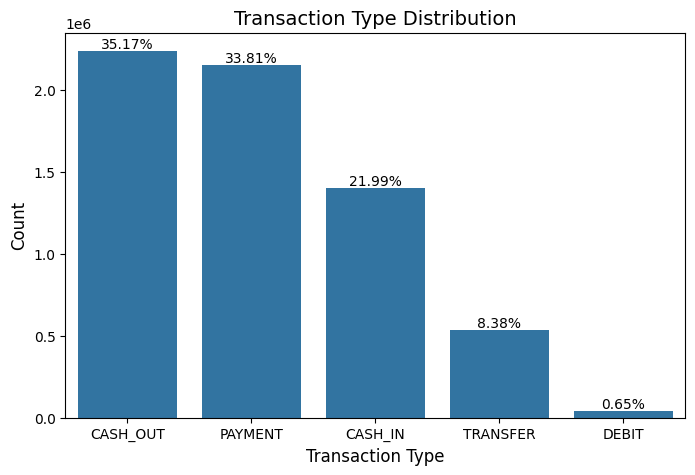

In [12]:
plt.figure(figsize=(8,5))
type_countplot = sns.countplot(x='type', data=df, order=type_percentages.index)

# Add labels to bars
for p in type_countplot.patches:
    percentage = round((p.get_height() / len(df)) * 100, 2)
    type_countplot.annotate(f'{percentage}%', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Transaction Type Distribution", fontsize=14)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

The majority of transactions in this dataset are CASH_OUT (35.17%) and PAYMENT (33.81%), followed by CASH_IN (21.99%). Meanwhile, TRANSFER (8.38%) and DEBIT (0.65%) are the least common transaction types.

<h3>Analysis on the 'isFraud' field</h3>

In [13]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

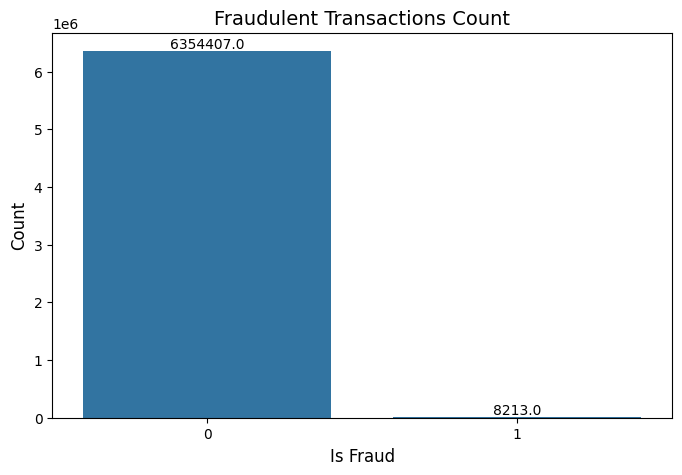

In [14]:
plt.figure(figsize=(8, 5))
is_fraud_countplot = sns.countplot(x='isFraud', data=df)

# Add labels to bars
for p in is_fraud_countplot.patches:
    count = p.get_height()
    is_fraud_countplot.annotate(f'{count}', 
                                (p.get_x() + p.get_width() / 2., count), 
                                ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Fraudulent Transactions Count", fontsize=14)
plt.xlabel("Is Fraud", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

The dataset is highly imbalanced, with only 8,213 fraudulent transactions out of over 6 million total records. Therefore, additional feature engineering and the use of data balancing techniques such as oversampling (e.g., SMOTE) or undersampling should be considered before training a machine learning model.

<h3> Variables Distribution </h3>

array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

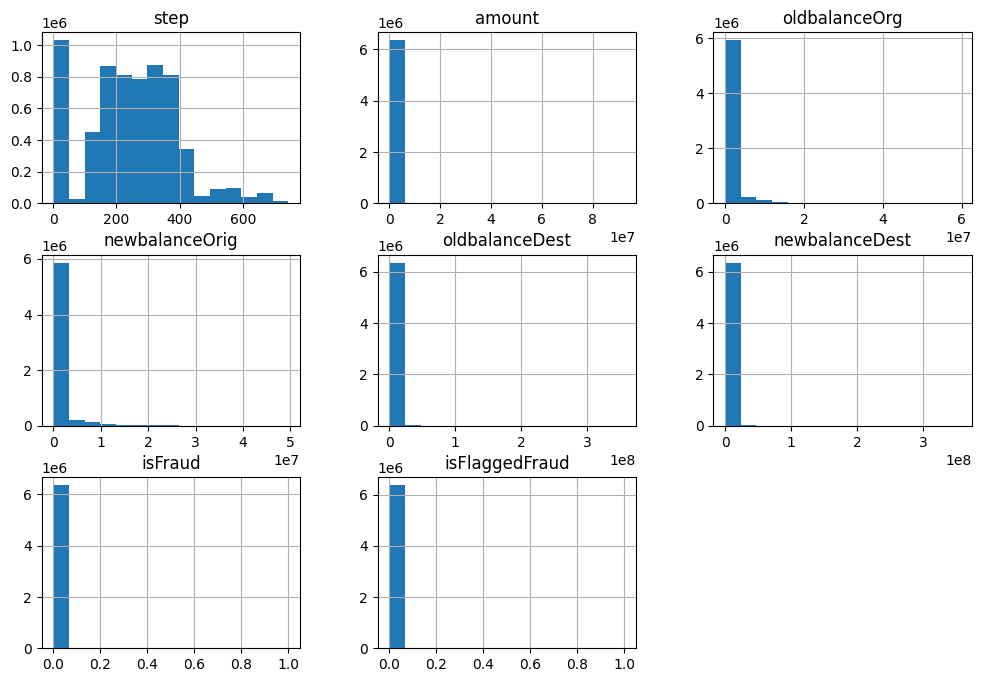

In [15]:
df.hist(figsize=(12, 8), bins=15)

<h3> Correlation Between Variables

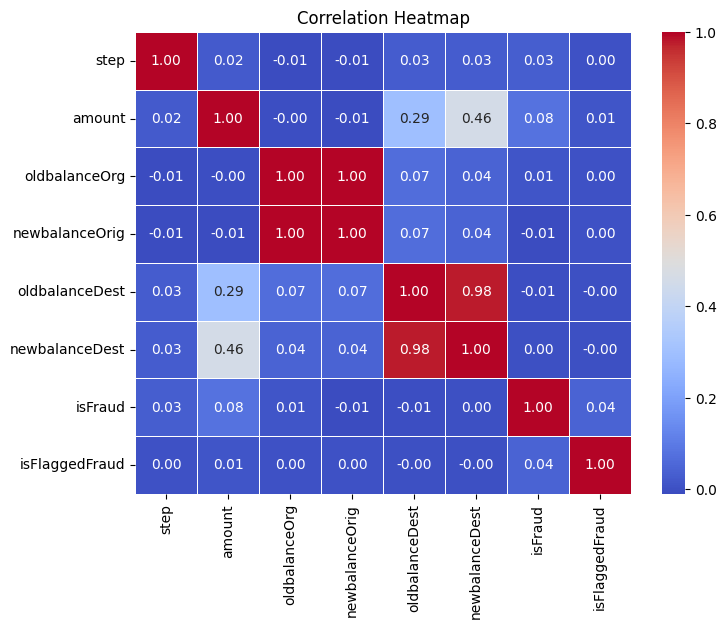

In [16]:
numeric_df = df.select_dtypes(include=['number'])
correlation_table = numeric_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<h3> Feature Importance with L1 Regularization

In [37]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['isFraud','type', 'nameOrig', 'nameDest','isFlaggedFraud']), df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

print("Coefficients:", lasso.coef_)
print("Intercept:", lasso.intercept_)
print("Training score:", lasso.score(X_train, y_train))


c:\Users\faldh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+03, tolerance: 6.602e-01
  model = cd_fast.enet_coordinate_descent(


Coefficients: [ 1.47058183e-06  1.34872141e-08  8.83034661e-08 -8.74387384e-08
  9.51212645e-09 -9.62671616e-09]
Intercept: 0.0009707752190739511
Training score: 0.15644867024606646


L1 regularization here was used to automatically detect important features, but the results show that current features like amount, old balance, and new balance are not very helpful for predicting fraud. The low coefficient values above suggest that the relationship between these features and fraud may be non-linear and complex. Since L1 regularization works best with linear relationships, it would be more effective to explore non-linear models such as XGBoost or LGBM for fraud detection.

<h3> Network Analysis</h3>

In [17]:
G = nx.from_pandas_edgelist(df, source='nameOrig', target='nameDest', edge_attr=['amount', 'isFraud'], create_using=nx.DiGraph)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 9073900
Number of edges: 6362620


In [18]:
density = nx.density(G)
reciprocity = nx.reciprocity(G)
transitivity = nx.transitivity(G)
clustering_coeffs = nx.clustering(G)
average_clustering = sum(clustering_coeffs.values()) / len(clustering_coeffs)

print("Graph Density:", density)
print("Reciprocity:", reciprocity)
print("Transitivity:", transitivity)
print("Average Local Clustering Coefficient:", average_clustering)


Graph Density: 7.727660903787649e-08
Reciprocity: 0.0
Transitivity: 0
Average Local Clustering Coefficient: 0.0


The network analysis shows that the fraud dataset creates a very sparse and disconnected graph, with no reciprocity, transitivity, or local clustering between users. This may suggest that the dataset contains isolated transactions for both fraud and non-fraudulent transactions, meaning that transactions occur separately rather than in groups here.

<h3> Network Analysis on Fraud label

Text(0.5, 1.0, 'Network Graph of Fraudulent Transactions (Amount = 10k)')

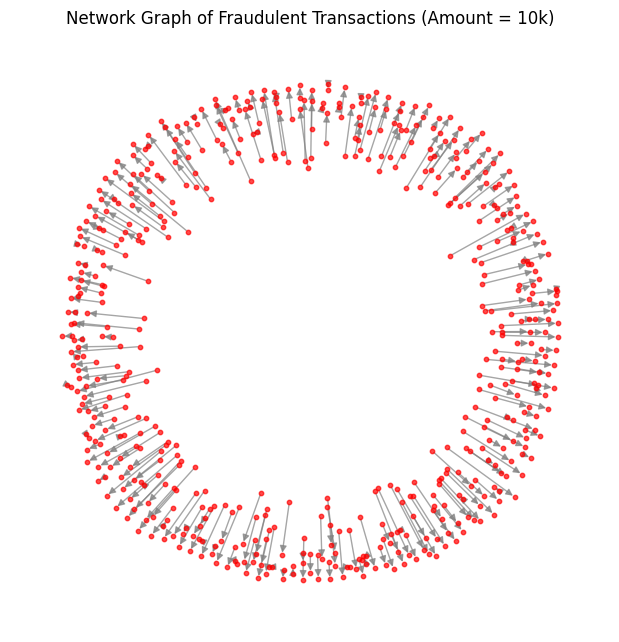

In [19]:
fraud_df_10k = df[(df['amount'] == 10000000) & (df['isFraud'] == 1)] #$1M is the most frequent transaction amount in the dataset

G_fraud_10k = nx.from_pandas_edgelist(fraud_df_10k, source='nameOrig', target='nameDest', edge_attr=['amount', 'isFraud'], create_using=nx.DiGraph)

plt.figure(figsize=(6, 6))
nx.draw(G_fraud_10k, with_labels=False, node_size=10, alpha=0.7, node_color='red', edge_color='gray')
plt.title("Network Graph of Fraudulent Transactions (Amount = 10k)")

In [20]:
density_fraud = nx.density(G_fraud_10k)
reciprocity_fraud = nx.reciprocity(G_fraud_10k)
transitivity_fraud = nx.transitivity(G_fraud_10k)
clustering_coeffs_fraud = nx.clustering(G_fraud_10k)
average_clustering_fraud = sum(clustering_coeffs.values()) / len(clustering_coeffs)

print("Graph Density:", density)
print("Reciprocity:", reciprocity)
print("Transitivity:", transitivity)
print("Average Local Clustering Coefficient:", average_clustering)


Graph Density: 7.727660903787649e-08
Reciprocity: 0.0
Transitivity: 0
Average Local Clustering Coefficient: 0.0


Even when focusing only on the fraud-labeled transactions, the graph still shows the same issues as the full fraud network. It has very low density, no reciprocity, no transitivity, and no local clustering. This suggests that there’s little evidence of coordinated fraud or organized networks, implying that fraudsters likely operate individually or use one-way transactions to escape with the funds. Given these characteristics, graph analysis might not be the best approach for detecting fraud in this dataset.

<h1><b> 4. Identifiying Fraud Patterns

<h3>1. What type of transactions are more likely to be fraudulent?</h3>

In [21]:
fraud_types = round(df.loc[df['isFraud'] == 1, 'type'].value_counts(normalize=True) * 100, 2)
print(fraud_types)

type
CASH_OUT    50.12
TRANSFER    49.88
Name: proportion, dtype: float64


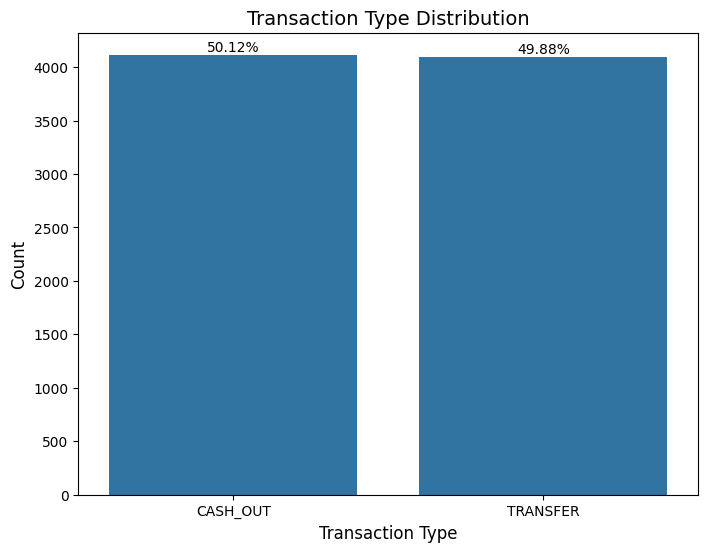

In [22]:
plt.figure(figsize=(8,6))
type_countplot = sns.countplot(x='type', data=df[df['isFraud']==1], order=fraud_types.index)

# Add labels to bars
for p in type_countplot.patches:
    percentage = round((p.get_height() / len(df[df['isFraud']==1])) * 100, 2)
    type_countplot.annotate(f'{percentage}%', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Transaction Type Distribution", fontsize=14)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Fraudulent transactions are found to only happened in CASH_OUT and TRANSFER types with nearly equal distribution. Although TRANSFER accounts for only 8.3% of all transactions in the dataset, it is primarily used for online fraud. Given this, it's important to implement tighter controls and enhanced monitoring for these two transaction types, especially during the initial stages of the transaction process.

<h3> 2. Are frauds concentrated in certain time periods(step)?

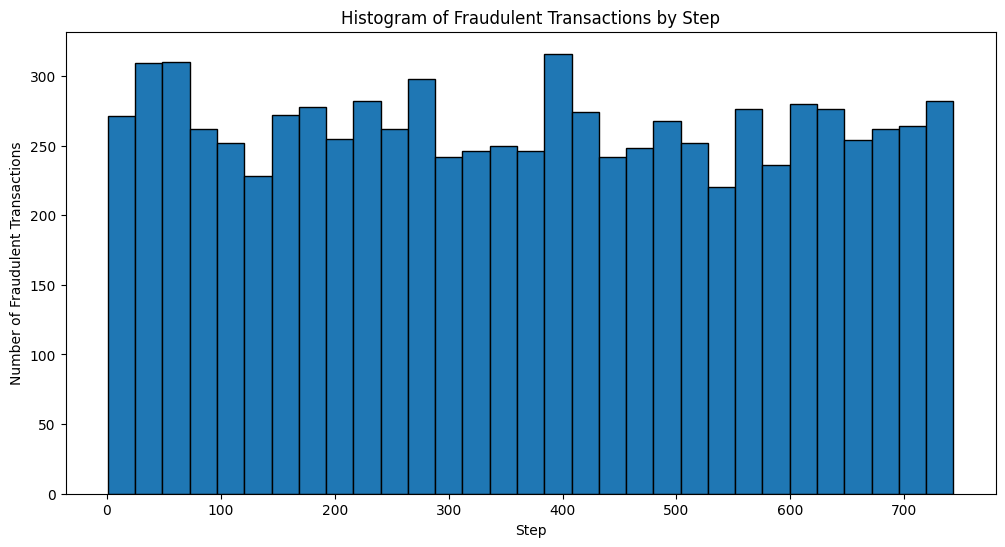

In [79]:
plt.figure(figsize=(12, 6))
plt.hist(df[df['isFraud']==1]['step'], bins=31, edgecolor='black') #31 days
plt.title('Histogram of Fraudulent Transactions by Step')
plt.xlabel('Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

The histogram here groups the fraud dataset into 31 bins (representing days) where the distribution appears relatively uniform. This suggests that fraudulent transactions are evenly spread across all time steps and not concentrated in specific time periods. This means fraud could happen at any time, so consistent monitoring is needed throughout the day, rather than focusing on certain times.

<h3>3. Does the timing of fraudulent transactions influence the transaction amount?

In [23]:
correlation = df['amount'].corr(df['step'])
print(f"Correlation between 'amount' and 'step': {correlation}")

Correlation between 'amount' and 'step': 0.022372994674588604


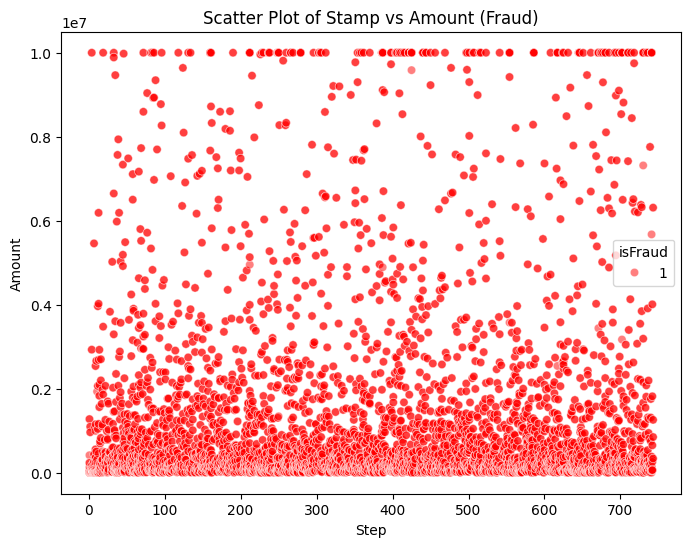

In [80]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='step', y='amount', data=df[df['isFraud']==1], hue='isFraud', palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.title('Scatter Plot of Stamp vs Amount (Fraud)')
plt.xlabel('Step')
plt.ylabel('Amount')
plt.show()

In this dataset, there is little evidence to say that a specific time period can be associate with large fraud amounts, as the correlation between time step and fraud amount is already very low (0.022). Furthermore, fraudulent transactions are seems to only happened between 0 and 10 million, and are distributed throughout the entire timeline, as shown in the scatter plot. This indicates that fraud occurs inconsistently, with both large and small fraud amounts potentially happening at any time.

In [25]:
df[df['isFraud']==1]['amount'].value_counts()

amount
10000000.00    287
0.00            16
429257.45        4
1165187.89       4
181.00           2
              ... 
181728.11        1
1078013.76       1
994453.20        1
5674547.89       1
416001.33        1
Name: count, Length: 3977, dtype: int64

Fraudsters seem to focus on quickly withdrawing large amounts, often targeting the 10 million limit, which could be the maximum they can access.

<h1><b> 5. Evaluating the Existing Fraud Detection System

In [26]:
TP = len(df[(df["isFraud"] == 1) & (df["isFlaggedFraud"] == 1)])
FN = len(df[(df["isFraud"] == 1) & (df["isFlaggedFraud"] == 0)])
FP = len(df[(df["isFraud"] == 0) & (df["isFlaggedFraud"] == 1)])
TN = len(df[(df["isFraud"] == 0) & (df["isFlaggedFraud"] == 0)])

# Calculate Metrics
accuracy = (TP + TN) / (TP + FN + FP + TN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1_score:.2%}")

Accuracy: 99.87%
Precision: 100.00%
Recall: 0.19%
F1-score: 0.39%


The current fraud detection system (isFlaggedFraud) is not performing well, with a recall of only 0.19%, meaning it misses almost all fraud cases. While the precision is 100%, this is misleading because the number of fraud cases is so low. The F1-score of 0.39% further highlights the system’s poor performance. The low recall also shows that the model is largely ineffective in identifying fraud, showing how poor the bank's fraud detection currently and emphasizing the need for a more effective predictive model.